In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [32]:
%load_ext tensorboar

ModuleNotFoundError: No module named 'tensorboar'

In [2]:
np.unique(plt.imread('data/set-lipstick/mask/mask00000050.png')[:,:,0]*255)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 109., 110., 111.,
       112., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
       146., 147., 148., 149., 150., 151., 152., 15

[  0 255]


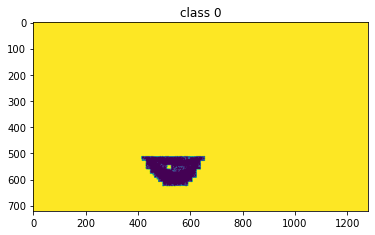

In [3]:
for i in range(1):
    mask = plt.imread('data/set-lipstick/mask/mask00000050.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    print(np.unique(mask))
    plt.imshow(mask)
    plt.title(f'class {i}')
    plt.show()

In [4]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('data/set-lipstick'):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            cameraRGB.append(f)
        elif 'mask' in f:
            cameraSeg.append(f)
        else:
            break

In [5]:
len(cameraRGB), len(cameraSeg)

(28594, 28540)

In [6]:
df = pd.read_csv('data/set-lipstick/list.csv')

In [7]:
df.shape

(28594, 9)

In [8]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [9]:
df['filename'] = 'data/set-lipstick/720p/' + df['filename'].astype(str)
df['mask'] = 'data/set-lipstick/mask/' + df['mask'].astype(str)

In [10]:
df.filename.head(3)

0    data/set-lipstick/720p/image00000001.jpg
1    data/set-lipstick/720p/image00000002.jpg
2    data/set-lipstick/720p/image00000003.jpg
Name: filename, dtype: object

In [11]:
idx_to_drop = []
for idx in df.index:
    row = df.iloc[idx]
    if not os.path.exists(row['filename']) or not os.path.exists(row['mask']):
        idx_to_drop.append(idx)
        
print(len(idx_to_drop))

54


In [12]:
df = df.drop(idx_to_drop, axis=0)
df = df[['filename', 'mask']]
df = df.reset_index(drop=True)

In [13]:
df.head(3)

,filename,mask
0,data/set-lipstick/720p/image00000001.jpg,data/set-lipstick/mask/mask00000001.png
1,data/set-lipstick/720p/image00000002.jpg,data/set-lipstick/mask/mask00000002.png
2,data/set-lipstick/720p/image00000003.jpg,data/set-lipstick/mask/mask00000003.png


In [14]:
def grey_mask(df):
    for index, row in df.iterrows():
        gray_image = Image.open(df.iloc[:,1][index]).convert('LA')
        gray_image.save(df.iloc[:,1][index])
        
    return df

In [15]:
# df = grey_mask(df)

In [16]:
labels = ['lips']

[  0 255]


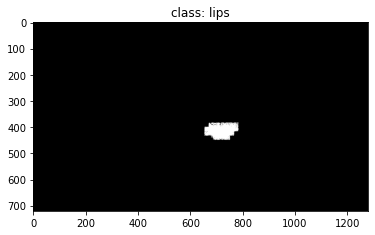

In [17]:
mask = plt.imread('data/set-lipstick/mask/mask00000001.png')*255
mask = np.where(mask >= 1, 255, 0)
print(np.unique(mask))
plt.title(f'class: {labels[i]}')
plt.imshow(mask)
plt.show()

Создадим класс для кастомного датасета:

In [18]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
        
        # convert str names to class values on masks
        # Конвертируем стринговые имена в значения класса на маске
        self.class_values = [labels.index(cls) for cls in labels]
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = Image.open(self.image_arr[index])
        # Преобразовываем к размеру 256х256
        img = img.resize((256,256))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # Количество каналов ставим на первый план - этого хочет pytorch
        img = img.permute(2,0,1).float()
        
        # Считываем нашу маску
        mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        mask = (mask[:,:] != 0)*1

        # Здесь мы создаем список бинарных масок из нашей одной общей маски 
        masks = [(mask == v) for v in self.class_values]
        # Стекаем все вместе в один многомерный тензор масок
        mask = np.stack(masks, axis=-1).astype('float')
        #  Приводим к типу тензора
        mask = torch.as_tensor(mask)
        # Размерность каналов на передний план
        mask = mask.permute(2,0,1)
        
        # делаем ресайз маски на 256х256
        # Для этого используем функцию interpolate
        ### Что бы ресайзить и высоту и ширину картинки, нужно перед interpolate
        ### пороизвести unsqueeze над тензором, и squeeze после.
        # unsqueeze - меняет размерность img c (256, 256, 3) -> (1, 256, 256, 3),
        mask = mask.unsqueeze(0)
        mask = F.interpolate(input=mask, size=256, mode='nearest')
        mask=mask.squeeze(0).squeeze(0)
        
        
        return (img, mask)

    def __len__(self):
        return self.data_len

In [20]:
df = df[:1000]

In [21]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [22]:
train_data_loader = DataLoader(train_data,batch_size=8,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=5,shuffle=False)

In [23]:
sample = iter(train_data_loader).next()

In [24]:
sample[0].size()

torch.Size([8, 3, 256, 256])

In [25]:
sample[1].size()

torch.Size([8, 256, 256])

In [26]:
learning_rate = 0.001
epochs = 5

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
import segmentation_models_pytorch as smp
import time

# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', encoder_weights = 'imagenet', classes=1, activation='sigmoid').to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=segmodel.parameters(), lr=0.001),
])

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

max_score = 0

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_smp_model.pth')
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|███████████████████████████████████| 60/60 [00:14<00:00,  4.11it/s, dice_loss - -3.822, iou_score - -1.686]

Epoch: 1
valid: 100%|███████████████████████████████████| 60/60 [00:15<00:00,  3.97it/s, dice_loss - -3.946, iou_score - -1.673]

Epoch: 2
valid: 100%|███████████████████████████████████| 60/60 [00:14<00:00,  4.09it/s, dice_loss - -3.938, iou_score - -1.678]

Epoch: 3
valid: 100%|███████████████████████████████████| 60/60 [00:14<00:00,  4.14it/s, dice_loss - -3.964, iou_score - -1.673]
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|████████████████████████████████████| 60/60 [00:14<00:00,  4.07it/s, dice_loss - -3.96, iou_score - -1.674]


In [29]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

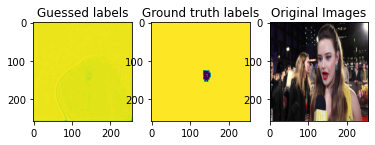

<ipython-input-33-56bf6482b338>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

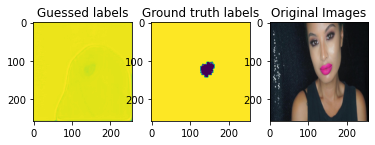

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

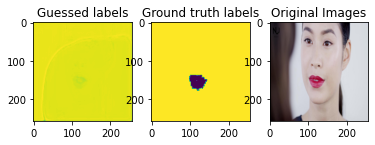

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

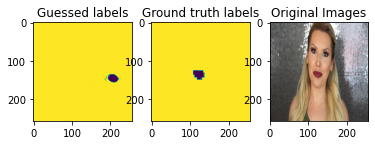

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

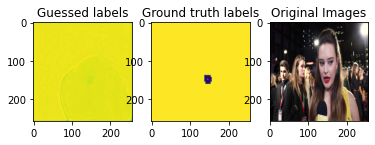

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

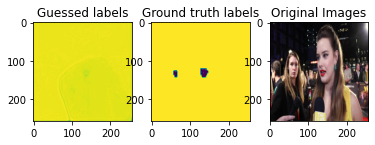

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

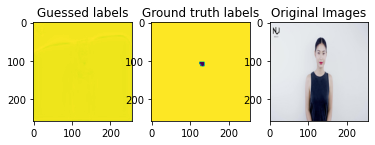

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [33]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = segmodel(images)
    f, axarr = plt.subplots(1,3)

    for j in range(0,5):
#         axarr[0].imshow(Image.fromarray(outputs.squeeze().detach().cpu().numpy()[j,:,:]))

        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,:,:])
        axarr[0].set_title('Guessed labels')

        axarr[1].imshow(labels.detach().cpu().numpy()[j,:,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
        plt.gcf().show()
    if i>5:
        break


In [ ]:
outputs.squeeze().detach().cpu().numpy()[1,:,:]